<a href="https://colab.research.google.com/github/AhnJG/AI-Project/blob/master/Colab/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 자습서는 RNN (Recurrent Neural Networks)을 사용한 시계열 예측에 대한 소개입니다. 이것은 두 부분으로 구성됩니다. 먼저, 일 변량 시계열을 예측 한 다음 다변량 시계열을 예측합니다.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


날씨 데이터 세트
이 튜토리얼은 Max Planck Institute for Biogeochemistry에 의해 기록 된 [날씨 시계열 데이터 세트]를 사용합니다 .

이 데이터 세트에는 대기 온도, 대기압 및 습도와 같은 14 가지 기능이 있습니다. 효율성을 위해 2009 년과 2016 년 사이에 수집 된 데이터 만 사용합니다.이 데이터 세트 섹션은 François Chollet이 그의 Deep Learning with Python을 위해 준비했습니다 .

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [3]:
print(csv_path, _)

/root/.keras/datasets/jena_climate_2009_2016.csv .zip


In [0]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


위에서 볼 수 있듯이, 관찰은 10 분마다 기록됩니다. 즉, 한 시간 동안 6 개의 관측 값을 갖게됩니다. 마찬가지로 하루에 144 개 (6x24)의 관측치가 포함됩니다.

특정 시간이 주어지면 앞으로 6 시간 동안 온도를 예측한다고 가정 해 봅시다. 이 예측을하기 위해 5 일간의 관찰을 사용하도록 선택합니다. 따라서 모형을 학습하기 위해 마지막 720 (5x144) 관측 값이 포함 된 창을 만듭니다. 이러한 많은 구성이 가능하므로이 데이터 세트를 실험하기에 적합합니다.

아래 함수는 모델이 훈련 할 때 위에서 설명한 시간 창을 반환합니다. 이 매개 변수 history_size는 과거 정보 창의 크기입니다. 이 target_size모델은 미래에 얼마나 멀리 예측을 배워야 하는가입니다. 는 target_size예측해야하는 레이블입니다.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

다음 두 자습서에서 데이터의 처음 300,000 개 행은 학습 데이터 세트이고 나머지는 유효성 검사 데이터 세트입니다. 이것은 ~ 2100 일 분량의 훈련 데이터에 해당합니다.

In [0]:
TRAIN_SPLIT = 300000

재현성을 보장하기 위해 시드 설정.

In [0]:
tf.random.set_seed(13)

## 1 부 : 일 변량 시계열 예측
먼저 단일 피쳐 (온도) 만 사용하여 모델을 학습하고 향후 해당 값을 예측하는 데 사용합니다.

먼저 데이터 세트에서 온도 만 추출해 봅시다.

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

이 데이터가 시간이 지남에 따라 어떻게 보이는지 관찰하십시오.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0036eb1208>],
      dtype=object)

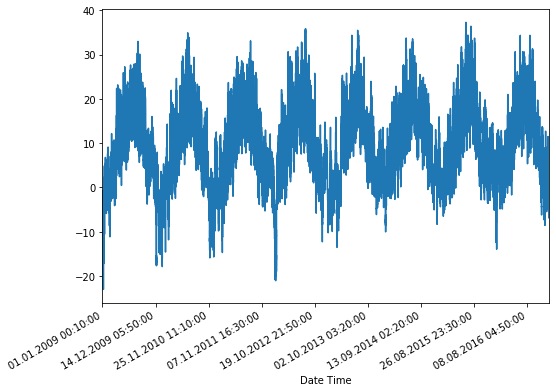

In [10]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

신경망을 훈련하기 전에 기능을 확장하는 것이 중요합니다. 표준화는 평균을 빼고 각 피처의 표준 편차로 나눔으로써이 스케일링을 수행하는 일반적인 방법입니다. 또한 tf.keras.utils.normalize값을 [0,1] 범위로 재조정 하는 방법을 사용할 수도 있습니다 .

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [13]:
print(uni_train_mean, uni_train_std)

9.233256299999999 8.636720398054864


데이터를 표준화합시다.

In [0]:
uni_data = (uni_data - uni_train_mean)/uni_train_std

In [15]:
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

이제 일 변량 모델에 대한 데이터를 만들어 봅시다. 1 부에서는 모델에 마지막 20 개의 기록 된 온도 관측치가 제공되며 다음 단계에서 온도를 예측하는 방법을 배워야합니다.

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

이것이 univariate_data함수가 반환하는 것입니다.

In [17]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


데이터가 생성되었으므로 단일 예제를 살펴 보겠습니다. 네트워크에 제공되는 정보는 파란색으로 표시되며 빨간 X표시 지점에서 값을 예측해야합니다.

In [0]:
def create_time_steps(length):
    return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

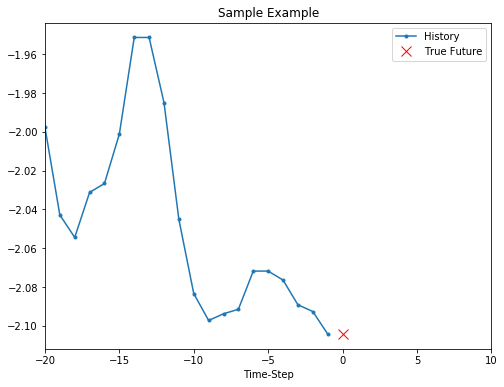

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### 베이스 라인
모델 학습을 진행하기 전에 먼저 간단한 기준을 설정하겠습니다. 입력 지점이 주어지면 기준선 방법은 모든 기록을보고 다음 지점이 마지막 20 개의 관측치의 평균이 될 것으로 예측합니다. ?? 뭔소리야

In [0]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

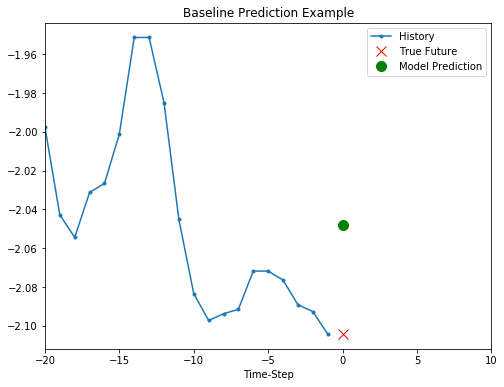

In [22]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
          'Baseline Prediction Example')

RNN을 사용하여이 기준을 이길 수 있는지 봅시다.

### RNN
RNN (Recurrent Neural Network)은 시계열 데이터에 적합한 신경 네트워크 유형입니다. RNN은 시계열을 단계별로 처리하여 지금까지 본 정보를 요약하여 내부 상태를 유지합니다. 자세한 내용은 RNN 튜토리얼을 읽으십시오 . 이 자습서에서는 긴 단기 메모리라는 전문 RNN 층 (사용 LSTM를 )

이제 tf.data데이터 세트를 셔플, 배치 및 캐시하는 데 사용하겠습니다 .

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

다음 시각화는 배치 후 데이터가 표시되는 방식을 이해하는 데 도움이됩니다.

LSTM에 데이터의 입력 형태가 필요하다는 것을 알 수 있습니다.

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [25]:
x_train_uni.shape[-2:] # (20,1)
x_train_uni.shape # (299980, 20, 1)

(299980, 20, 1)

모델의 출력을 확인하기 위해 샘플 예측을 만들어 봅시다.

In [26]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


모델을 훈련시켜 봅시다. 데이터 세트의 크기가 크기 때문에 시간 절약을 위해 각 에포크는 정상적으로 수행되는 전체 교육 데이터 대신 200 단계 동안 만 실행됩니다.

In [27]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0317 - val_loss: 0.0226
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0287 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1

### 간단한 LSTM 모델을 사용하여 예측
간단한 LSTM을 학습 했으므로 몇 가지 예측을 시도해 보겠습니다

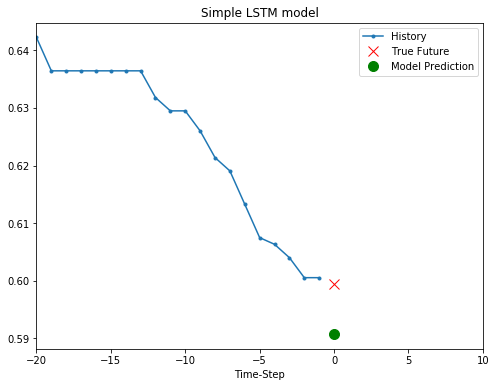

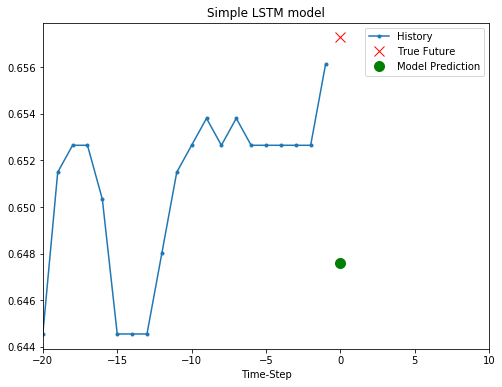

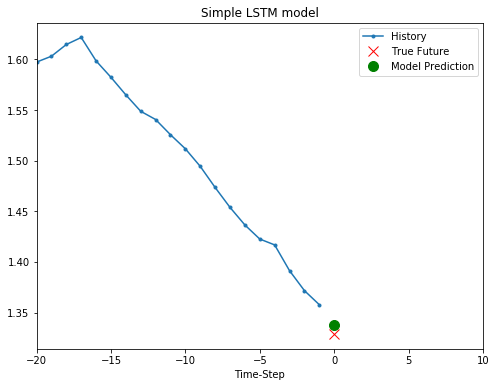

In [28]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

이것은 기준선보다 나아 보입니다. 이제 기본 사항을 살펴 봤으니, 다변량 시계열을 다루는 2 부로 넘어가겠습니다.

### 2 부 : 다변량 시계열 예측
원본 데이터 세트에는 14 개의 특성이 있습니다. 간단하게하기 위해이 섹션에서는 원래 14 개 중 3 개만 고려합니다. 사용되는 특성은 대기 온도, 대기압 및 공기 밀도입니다.

더 많은 특성을 사용하려면 해당 이름을 목록에 추가하십시오.

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [30]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


이러한 각 기능이 시간에 따라 어떻게 다른지 살펴 보겠습니다.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7effaf3c6c88>,
      dtype=object)

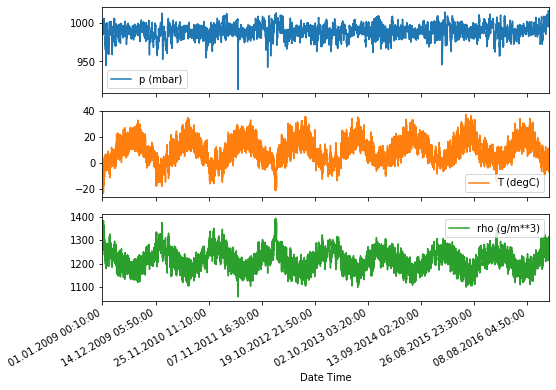

In [31]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset - data_mean) / data_std

### 단일 단계 모델
단일 단계 설정에서 모델은 제공된 일부 이력을 기반으로 미래의 단일 지점을 예측하는 방법을 학습합니다.

아래 함수는 아래와 동일한 윈도우 작업을 수행하지만 여기서는 주어진 단계 크기를 기반으로 과거 관측치를 샘플링합니다.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

이 자습서에서는 네트워크에 지난 5 일 동안의 데이터, 즉 매 시간마다 샘플링되는 720 개의 관측치가 표시됩니다. 60 분 내에 급격한 변화가 예상되지 않으므로 샘플링은 1 시간마다 수행됩니다. 따라서 120 개의 관측치는 지난 5 일의 이력을 나타냅니다. 단일 단계 예측 모델의 경우 데이터 포인트의 레이블은 향후 12 시간의 온도입니다. 이를위한 레이블을 만들기 위해 72 (12 * 6) 관찰 후 온도가 사용됩니다.

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [36]:
dataset[: 1]

array([[ 0.95547359, -1.99766294,  2.2350791 ]])

단일 데이터 포인트를 살펴 보겠습니다.

In [37]:
print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [38]:
x_train_single.shape # 299280, 120, 3
y_train_single.shape # 299280, 

x_val_single.shape # 119759, 120, 3
y_val_single.shape # 119759

(119759,)

In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

샘플 예측을 확인해 봅시다.

In [41]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [42]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 19ms/step - loss: 0.3090 - val_loss: 0.2646
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2624 - val_loss: 0.2437
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2614 - val_loss: 0.2472
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2567 - val_loss: 0.2445
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2265 - val_loss: 0.2339
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2416 - val_loss: 0.2692
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2415 - val_loss: 0.2556
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2411 - val_loss: 0.2384
Epoch 9/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2450 - val_loss: 0.2474
Epoch 10/10
200/200 [===========================

In [0]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

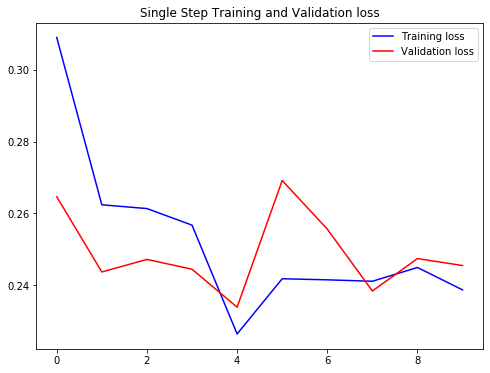

In [44]:
plot_train_history(single_step_history, 'Single Step Training and Validation loss')

### 한 걸음 미래 예측
모델이 학습되었으므로 몇 가지 샘플 예측을 만들어 보겠습니다. 온도를 예측하는 것이 목표이기 때문에 플롯은 과거 온도 만 표시하기 때문에 모델에는 지난 5 일 동안 매 시간마다 샘플링 된 세 가지 기능 (120 데이터 포인트)의 이력이 제공됩니다. 예측은 언젠가 미래로 만들어집니다 (따라서 역사와 예측 사이의 간격).

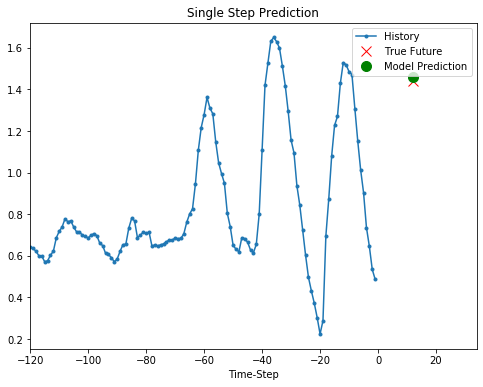

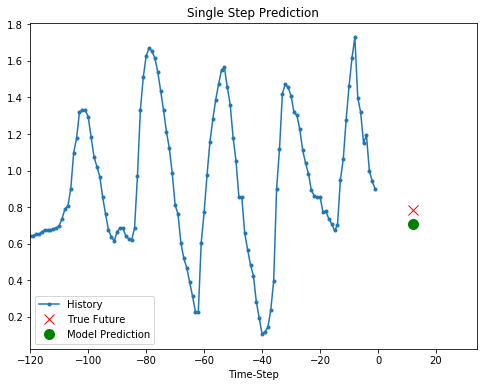

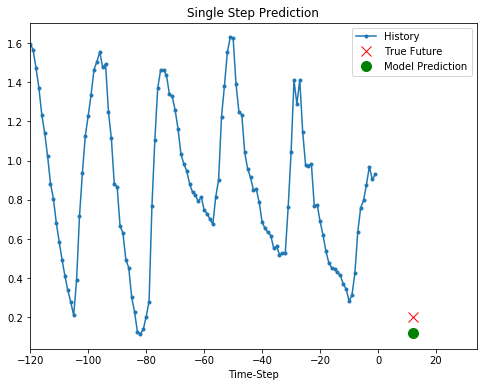

In [45]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 12, 
                     'Single Step Prediction')
    plot.show()

### 다단계 모델
다단계 예측 모델에서 과거 히스토리가 주어지면 모델은 미래의 값 범위를 예측하는 법을 배워야합니다. 따라서 단일 미래 포인트 만 예측되는 단일 단계 모델과 달리 다단계 모델은 미래의 시퀀스를 예측합니다.

다단계 모델의 경우 훈련 데이터는 다시 한 시간마다 샘플링 된 지난 5 일 동안의 기록으로 구성됩니다. 그러나 여기서는 12 시간 동안 온도를 예측하는 방법을 학습해야합니다. 10 분마다 관측이 수행되므로 결과는 72 개의 예측입니다. 이 작업을 위해서는 데이터 세트를 적절히 준비해야하므로 첫 번째 단계는 다시 대상 창을 사용하여 다시 작성하는 것입니다.

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

샘플 데이터 포인트를 확인하십시오.

In [47]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [48]:
dataset[:, 1].shape # (420551,)
dataset.shape # (420551, 3)
dataset[:,1].shape # (1, 3)


(420551,)

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

샘플 데이터 포인트를 플로팅합니다.

In [0]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='Ture Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

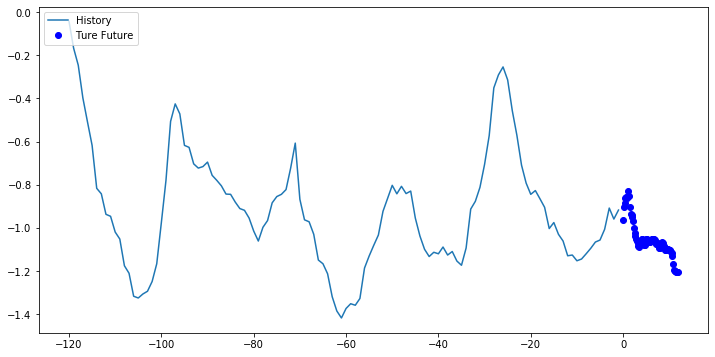

In [51]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

여기서의 작업은 이전 작업보다 조금 더 복잡하기 때문에 모델은 이제 두 개의 LSTM 계층으로 구성됩니다. 마지막으로, 72 개의 예측이 이루어 지므로, Dense 계층은 72 개의 예측을 출력한다.

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

학습하기 전에 모델이 어떻게 예측하는지 봅시다.

In [55]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 72)


In [57]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                           validation_data=val_data_multi,
                                           validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 27s 134ms/step - loss: 0.5007 - val_loss: 0.3008
Epoch 2/10
200/200 [==============================] - 25s 123ms/step - loss: 0.3482 - val_loss: 0.2877
Epoch 3/10
200/200 [==============================] - 26s 128ms/step - loss: 5.0761 - val_loss: 0.2868
Epoch 4/10
200/200 [==============================] - 25s 126ms/step - loss: 0.3124 - val_loss: 0.2408
Epoch 5/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2152 - val_loss: 0.2041
Epoch 6/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2111 - val_loss: 0.2122
Epoch 7/10
200/200 [==============================] - 25s 124ms/step - loss: 0.2007 - val_loss: 0.2101
Epoch 8/10
200/200 [==============================] - 25s 124ms/step - loss: 0.1952 - val_loss: 0.2009
Epoch 9/10
200/200 [==============================] - 25s 126ms/step - loss: 0.1978 - val_loss: 0.1853
Epoch 10/10
200/200 [=========

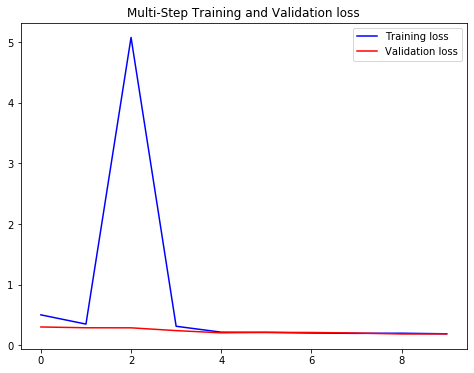

In [58]:
plot_train_history(multi_step_history, 'Multi-Step Training and Validation loss')

### 다단계 미래 예측
이제 네트워크가 미래를 예측하는 방법을 얼마나 잘 배웠는지 살펴 보겠습니다.

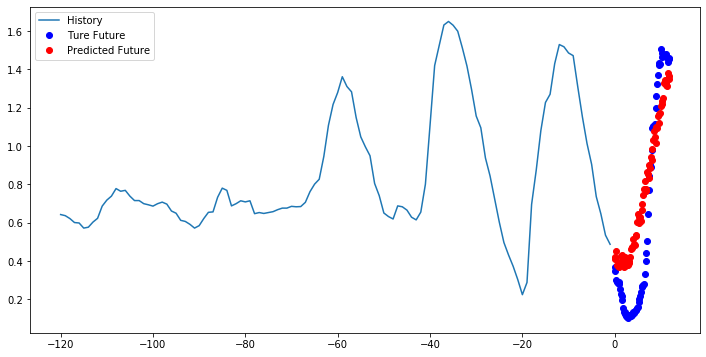

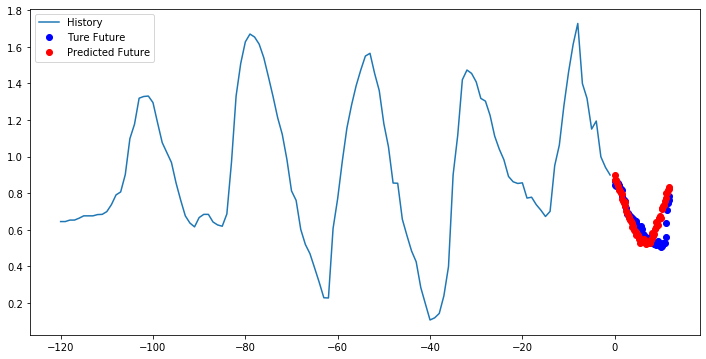

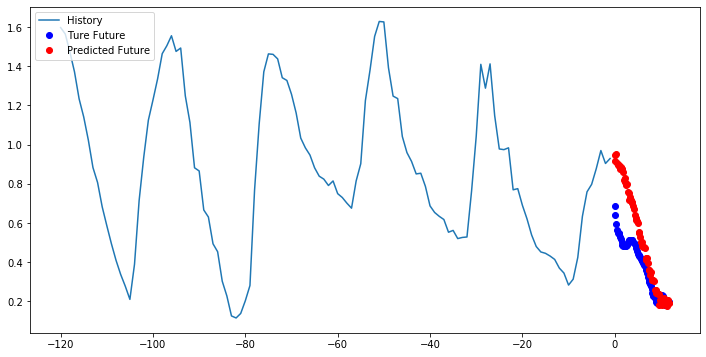

In [60]:
for x,y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

### 다음 단계
이 자습서는 RNN을 사용한 시계열 예측에 대한 빠른 소개입니다. 이제 주식 시장을 예측하고 억만 장자가 될 수 있습니다.

또한 메모리를 효율적으로 사용하는 uni / multivariate_data 함수 대신 데이터를 생성하는 생성기를 작성할 수도 있습니다. 이 시계열 윈도우 가이드를 확인 하여이 자습서에서 사용할 수도 있습니다.

더 이해하려면 Scikit-Learn, Keras 및 TensorFlow를 사용한 실습 머신 러닝 15 장 , 2 판 및 Python을 사용한 딥 러닝 6 장 을 읽으십시오 .